In [1]:
import os
import numpy as np
import lda
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import shutil  # 用于复制文件
import time

In [3]:
# 定义函数，读取所有的输入txt文件，获得所有的报文数据
# 参数：文件夹名称，txt后缀
# 返回值：所有报文构成的列表，列表每个元素代表一条报文
def read_input(packet_name):
    
    packets = []  # 存放所有报文，每个元素代表一个报文
    file_list = os.listdir(packet_name)
    num = len(file_list)  # 文件夹下报文txt个数
    
    for i in range(1, num+1):
        
        # 每个文件名
        read_file_name = packet_name + '\\' + str(i) + '.txt'
    
        # 打开，整体读取，而非按行读取
        f = open(read_file_name, 'r')
        content = f.read()
        f.close()
        
        # 存入列表中
        packets.append(content)
    
    return packets

In [4]:
# 定义函数，对高频n-grams列表预处理，为每个 n-gram 赋予编号，报文使用 n-gram 编号的列表表示，组织训练数据矩阵
# 参数：各个报文的高频n-grams列表，大列表套小列表形式
# 返回值：四个
# 1. new_packets  所有报文的编号列表，每个报文对应一个存放n-gram编号的小列表
# 2. ngram2id  字典，键为 n-gram，值为 id
# 3. id2ngram  字典，键为 id，值为 n-gram
# 4. X  组织好的训练数据，每一行代表一个报文，每一列为一个n-gram，(i, j)代表第i个文档中第j个n-gram出现的次数

def preprocess(packets):
    # 初始化
    ngram2id = {}  # 字典，键为 n-gram，值为 id
    id2ngram = {}  # 字典，键为 id，值为 n-gram
    new_packets = []  # 存放所有报文的编号列表，每个报文对应一个存放n-gram编号的小列表
    currentPacket = []  # 当前报文的编号列表
    currentId = 0  # n-gram当前编号到哪个数字了
    # 对n-gram和报文进行编号
    for message in packets:  # 遍历每个报文
        for ngram in message:   # 遍历报文的每个n-gram
            if ngram in ngram2id:  # 如果该n-gram已经编号过
                currentPacket.append(ngram2id[ngram])  # 直接记录该报文的n-gram编号即可
            else:  # 如果该n-gram未编号过
                ngram2id[ngram] = currentId  # 先分别在两个列表中对该n-gram进行编号
                id2ngram[currentId] = ngram
                currentPacket.append(currentId)  # 再记录报文的n-gram编号
                currentId += 1
        new_packets.append(currentPacket)  # 存储该报文的编号列表
        currentPacket = []
    # 组织训练数据
    row = len(packets)
    col = len(ngram2id)
    X = np.zeros([row, col], dtype=int)  # 要指定int，不然model.fit(X)会报错说无法将float64转化为int64
    for i in range(row):  # 遍历报文，填充矩阵值
        for j in new_packets[i]:
            X[i, j] += 1
    return new_packets, ngram2id, id2ngram, X

In [5]:
# 定义函数，输入相应的参数，并得到模型
# 参数
# 返回值：训练好的模型

def get_model(packet_name, n_topics, n_iter, alpha, eta):
    
    packets = read_input(packet_name)
    num = len(packets)
    for i in range(num):
        packets[i] = packets[i].split("####")
    
    # 预处理，得到编号以及训练数据
    new_packets, ngram2id, id2ngram, X = preprocess(packets)
    # 训练模型
    model = lda.LDA(n_topics=n_topics, n_iter=n_iter, alpha=alpha, eta=eta, random_state=1)
    model.fit(X)
    return model


In [6]:
# 定义函数，训练lda模型并使用其结果对原始文件聚类，结果存到不同的文件中
# 参数：除了模型 参数，还加了一个n_cluster，簇的最大个数

def get_clusters(packet_name, model, n_cluster):
    
    message_topic = model.doc_topic_
    
    # 层次聚类，且是自底向上的凝聚聚类
    X = message_topic  # 输入数据，lda模型得到的矩阵
    disMat = sch.distance.pdist(X, 'euclidean')  # 生成点与点之间的距离矩阵,使用欧氏距离
    Z = sch.linkage(disMat, method='average')  # 层次聚类编码为一个linkage矩阵
    
    # 画图
    P = sch.dendrogram(Z)
    plt.title('Dendrogram')
    plt.xlabel('Messages')
    plt.ylabel('Euclidean distances')
    plt.show()
    cluster = sch.fcluster(Z, t=n_cluster, criterion='maxclust')  # 指定簇的个数最大为4
    print("\n聚类结果为：\n", cluster)
    return cluster

In [14]:
# 定义函数：根据聚类结果将不同报文存储到不同的文件夹中
# 参数：
# packet_name：原始文件夹名
# file_suffix：txt文件名的协议名后缀
# n_cluster为簇的个数
# cluster每个元素代表该报文的簇别

def save_cluster(packet_name, n_cluster, cluster):
    
    for i in range(n_cluster):  # 对于每个簇
        num = 0  # 初始化计数
        cluster_name = 'cluster' + str(i+1)  # 创建该簇的文件夹
        os.mkdir(cluster_name)
        
        for j in range(len(cluster)):  # 遍历每个报文的簇别数
            if cluster[j] == (i+1):
                num += 1
                old_path = packet_name + '\\' + str(j+1) + '.txt'  # 新旧地址
                new_path = cluster_name + '\\' + str(num) + '.txt'
                f = open(new_path, 'w')  # 创建新的文件夹
                f.close()
                shutil.copyfile(old_path, new_path)
        print("第%d个簇共有%d条报文数据" % (i+1, num))
    print("文件保存成功")

INFO:lda:n_documents: 100
INFO:lda:vocab_size: 872
INFO:lda:n_words: 68973
INFO:lda:n_topics: 4
INFO:lda:n_iter: 400
INFO:lda:<0> log likelihood: -538119
INFO:lda:<10> log likelihood: -504055
INFO:lda:<20> log likelihood: -489848
INFO:lda:<30> log likelihood: -479316
INFO:lda:<40> log likelihood: -471140
INFO:lda:<50> log likelihood: -464771
INFO:lda:<60> log likelihood: -459626
INFO:lda:<70> log likelihood: -454998
INFO:lda:<80> log likelihood: -451686
INFO:lda:<90> log likelihood: -449584
INFO:lda:<100> log likelihood: -447992
INFO:lda:<110> log likelihood: -446354
INFO:lda:<120> log likelihood: -444648
INFO:lda:<130> log likelihood: -443444
INFO:lda:<140> log likelihood: -442082
INFO:lda:<150> log likelihood: -440354
INFO:lda:<160> log likelihood: -439228
INFO:lda:<170> log likelihood: -438456
INFO:lda:<180> log likelihood: -437780
INFO:lda:<190> log likelihood: -436560
INFO:lda:<200> log likelihood: -436913
INFO:lda:<210> log likelihood: -436902
INFO:lda:<220> log likelihood: -4366

lda模型训练结束，开始进行聚类


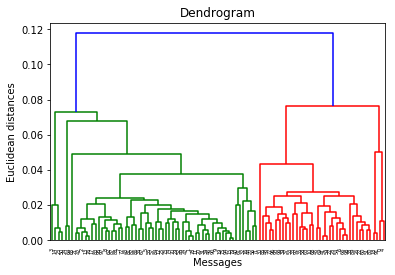


聚类结果为：
 [2 1 1 1 2 1 2 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 2 2 2 1 2 1 1 2 1 2 1
 2 2 2 1 2 1 1 1 2 1 1 2 1 1 2 1 2 2 1 1 1 2 2 2 1 1 2 1 1 2 1 2 2 1 1 1 1
 1 1 1 2 1 1 2 1 1 1 1 2 1 1 1 2 1 2 2 2 1 1 2 1 2 2]

开始保存各个簇文件
第1个簇共有62条报文数据
第2个簇共有38条报文数据
文件保存成功

两个模块运行时间： 3.1167001724243164 秒


In [13]:
begin_time = time.time()  # 统计程序运行时间

model = get_model('freq-ngrams', 4, 400, 0.5, 0.005)
print("lda模型训练结束，开始进行聚类")
cluster = get_clusters('freq-ngrams', model, 2)
print("\n开始保存各个簇文件")
save_cluster('input', 2, cluster)

end_time = time.time()
run_time = end_time - begin_time
print ('\n两个模块运行时间：',run_time, '秒')